In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io
from skimage import measure

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from model import QNetwork, get_parameters
import warnings
warnings.filterwarnings("ignore")

# Methods
* Use difference image to find pacman and ghosts
* Use skimage measure to find connected components:
* if color==146
  * small objects are dots
  * bigger objects are powerups
  * biggest objects are obstacles
* if color==167
  * pacman
* if color==32
  * background
* elif
  * ghosts
  * screw fruits for now
  * or maybe only detect ghosts using difference image?


* Obstacles and backgronud are always the same. Therefore we should only calculate them once

# Versions
0) Just rescale/crop image
1) Maze as grid, including player/enemy/obstacles/dots
2) Coordinates of player/enemy/obstacles/dots

In [30]:
%matplotlib qt

In [32]:
%matplotlib inline

In [31]:
env = gym.make('ALE/MsPacman-v5',full_action_space=False, obs_type='grayscale') 
s = env.reset()
io.imshow(s)
for i in range(70):
    new_s, r, done, _ = env.step(env.action_space.sample())
    diff = new_s - s
    s = new_s

In [ ]:
io.imshow(diff)

In [ ]:
s = env.reset()
s = s[6:170,5:-5]

h = s.shape[0]
w = s.shape[1]

h_size = 14 #14/15
w_size = 18 #18/19

hs = 11.7#/4
ws = 8.35#/4

s = rescale(s, 1, anti_aliasing=False)*255

mask = np.zeros(s.shape, dtype=bool)
for i in range(h_size):
    for j in range(w_size):
        #mask[int(i*hs),int(j*ws)]=255
        mask[int(i*hs+hs/2),int(j*ws+ws/2)]=True
        

        
#s[mask] = 255
grid = s[mask].reshape((14,18))
bin_img = s
bin_img[s>50] = 255
bin_img[s==0] = 0

io.imshow(s, cmap='gray')
io.imshow(mask, cmap='gray')
plt.show()

In [ ]:
s = env.reset()
s = s[6:170,5:-5]

h = s.shape[0]
w = s.shape[1]



h_size = 14 #14/15
w_size = 18 #18/19

hs = 11.7/4
ws = 8.35/4

s = rescale(s, 0.25, anti_aliasing=False)*255

mask = np.zeros(s.shape, dtype=bool)
for i in range(h_size):
    for j in range(w_size):
        #mask[int(i*hs),int(j*ws)]=255
        mask[int(i*hs+hs/2),int(j*ws+ws/2)]=True
        

        
#s[mask] = 255
grid = s[mask].reshape((14,18))
bin_img = s
bin_img[s>50] = 255
bin_img[s==0] = 0

io.imshow(s, cmap='gray')
#io.imshow(mask, cmap='gray')
plt.show()

In [ ]:
from skimage import measure
label_img = measure.label(bin_img, connectivity=2)
io.imshow(label_img)

In [ ]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

In [ ]:
grid = np.zeros(s.shape)
grid2 = np.zeros((14,18))
for region in region_props:
    
    # background
    if region.area == 15709:
        for cords in region.coords:
            grid[cords[0], cords[1]] = 0
            #grid2[int(cords[0]/hs), int(cords[1]/ws)] = 0
            
    # pellet
    if region.area == 8:
        x, y = region.centroid
        grid[int(x), int(y)] = 2
        grid2[int(x/hs), int(y/ws)] = 2
    
    # powerup
    if region.area == 28:
        x, y = region.centroid
        grid[int(x), int(y)] = 3
        grid2[int(x/hs), int(y/ws)] = 3
        #for cords in region.coords:
        #    grid[cords[0], cords[1]] = 3
        #    grid2[int(cords[0]/hs), int(cords[1]/ws)] = 3
            
    # player/enemy
    if region.area in [41, 60, 76]:
        for cords in region.coords:
            grid[cords[0], cords[1]] = 4
            #grid2[int(cords[0]/hs), int(cords[1]/ws)] = 4
    
    # obstacles
    if region.area in [36, 80, 84, 96, 144, 192, 216, 288, 384, 432, 528, 559, 576]:
        for cords in region.coords:
            grid[cords[0], cords[1]] = 1
            #grid2[int(cords[0]/hs), int(cords[1]/ws)] = 1
            
    
plt.imshow(grid2)
#plt.grid(which='minor', color='black', linewidth=1)
#plt.grid(which='major', color='black', linewidth=1)
#plt.minorticks_on()

In [ ]:
s = env.reset()
s = rescale(s, 0.25, anti_aliasing=False)*255
s = s[6:170,5:-5]

hs = 11.7/4
ws = 8.35/4

label_img = measure.label(s, connectivity=2)
region_props = measure.regionprops(label_img)

grid = np.zeros(s.shape)
grid2 = np.zeros((14,18))
for region in region_props:
    # background
    if region.area == 617:
        for cords in region.coords:
            #grid[cords[0], cords[1]] = 1
            grid2[int(cords[0]/hs), int(cords[1]/ws)] = 1
             
plt.imshow(grid2)

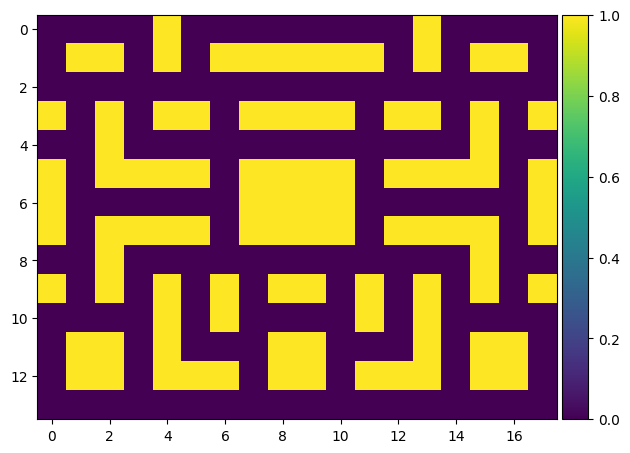

In [172]:
track = np.loadtxt('map/map_track.txt', dtype='i', delimiter=',')
io.imshow(track)

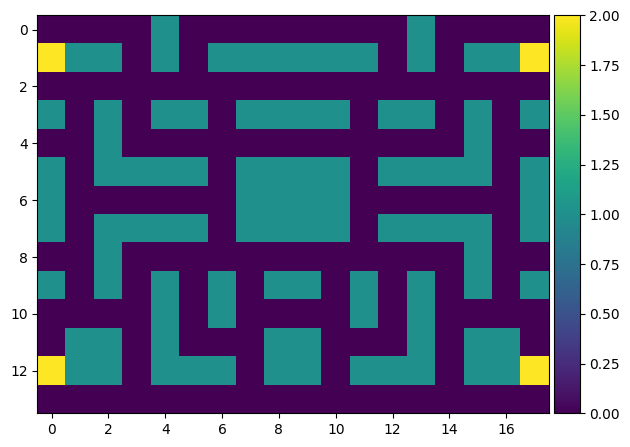

In [155]:
pellets = np.loadtxt('map/map_pellet.txt', dtype='i', delimiter=',')
io.imshow(pellets)

In [4]:
pacman_col = 167
g1_col = 110
g2_col = 131
g3_col = 132
g4_col = 151

In [121]:
def where(s):
    w = 18/s.shape[1]
    h = 14/s.shape[0]
    entities = [None,None,None,None,None]
    
    for x in range(s.shape[1]):
        for y in range(s.shape[0]):
            if not entities[0] and s[y,x]==pacman_col:
                   entities[0]=(int(y*h),int(x*w))
                    
            elif not entities[1] and s[y,x]==g1_col:
                     entities[1]=(int(y*h),int(x*w))
                    
            elif not entities[2] and s[y,x]==g2_col:
                     entities[2]=(int(y*h),int(x*w))
                    
            elif not entities[3] and s[y,x]==g3_col:
                     entities[3]=(int(y*h),int(x*w))
                    
            elif not entities[4] and s[y,x]==g4_col:
                     entities[4]=(int(y*h),int(x*w))
    return entities

In [173]:
s = env.reset()
s = s[6:170,5:-5]

maps = []
states = []
smap = track.copy()
for i in range(100):  
    
    
    entities = where(s)
            
    for ent in entities[0:1]:
        if ent != None:
            here = smap[ent[0],ent[1]]
            #if here !=1:
            smap[ent[0],ent[1]]=3
                
    for ent in entities[1:]:
        if ent != None:
            here = smap[ent[0],ent[1]]
            #if here !=1:
            smap[ent[0],ent[1]]=2
    
    maps.append(smap)
    states.append(s)
    
    a = env.action_space.sample()
    s, r, done, _ = env.step(a)
    s = s[6:170,5:-5]


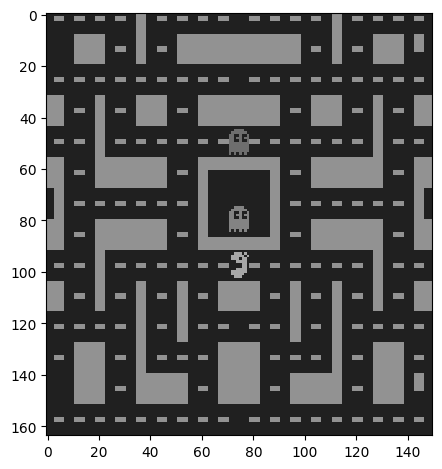

In [174]:
io.imshow(states[0])

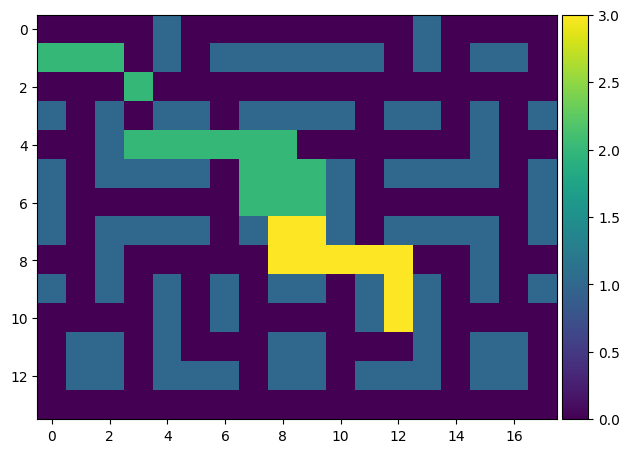

In [175]:
io.imshow(maps[0])